# Анализ статистик по [dicechess.com](https://www.dicechess.com/): дубли, сеты и не только

## Импорт необходимых библиотек

**!!!ВАЖНО!!!** Для воспроизводимости экспериментов необходимо выполнить шаги преподготовки, описаные в [README](https://github.com/EliseevVadim/dicechess-analysis/blob/main/README.md), иначе загрузчик партий с [dicechess.com](https://www.dicechess.com/) не будет работать

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from core.data_preparation import *
from core.utils import init_random_seed

Для воспроизводимости отображений в сэмплах и не только

In [4]:
init_random_seed(893)

## Загрузка данных об игроке

В данном ноутбуке проверим средний процент дублей и сетов в партиях пользователя сайта [dicechess.com](https://www.dicechess.com/), сыгравшего наибольшее количество игр  - [Qtrie](https://www.dicechess.com/profile/482)

In [5]:
USER_ID = '482'

Чтобы проанализировать партии другого игрока, необходимо зайти на его профиль на dicechess.com и скопировать значение из URL, следующее за "/profile/" (выделено на скриншоте) и поместить его в переменную `USER_ID`

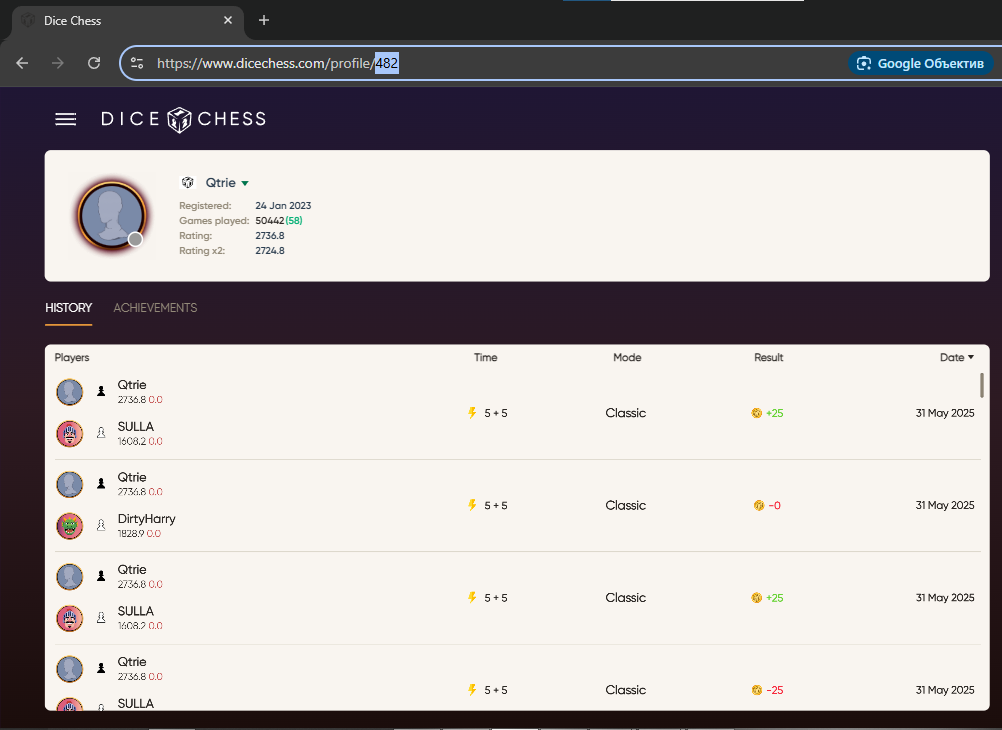

Загрузим сводку по партиям игрока. В качестве 2-го параметра функции необходимо установить любое значение, превышающее число сыгранных игроком партий 

In [6]:
%%time
summary = load_games_summary(USER_ID, 51000)
summary.sample(10)

CPU times: total: 1min 46s
Wall time: 2min 12s


,game_id,color,opponent_id,opponent_name
29013,de01f6e2-8344-11ef-b338-37e8c37116f6,WHITE,-43,BOT
29529,e8d7abcd-80bc-11ef-818c-87a0bd6baee5,WHITE,-43,BOT
36330,36f68033-3e98-11ef-99af-c57a6bd2d94a,WHITE,-43,BOT
39186,2439f2bf-1e7c-11ef-b222-1b4eee34345b,WHITE,2372,Darkf1ame
15745,a5ea8fa9-cf54-11ef-958a-dd1495e95155,BLACK,2010,Alehandro081
15813,defb6b0d-cec6-11ef-958a-9b9773085e9a,WHITE,-43,BOT
1565,2e4c0db6-34b0-11f0-8d9b-1ddfad556071,WHITE,-43,BOT
35274,5fc93a73-45a8-11ef-975e-d59f30bef168,WHITE,1845,AlexAlx
8771,b17ae63f-fd2a-11ef-99c0-a50280550267,BLACK,411062,dfgsdfgsdf
50115,740a062b-a76a-11ee-8f2c-fde63382a2c1,WHITE,-43,BOT


Посмотрим сколько уникальных соперников было у игрока **(just for fun)**

In [7]:
summary.opponent_name.nunique()

1638

И топ-20 соперников игрока по числу общих партий

In [8]:
summary.opponent_name.value_counts().to_frame().head(20)

,count
opponent_name,
BOT,26019
Perez,1566
VadimCernov,558
Momus,547
pekas,438
Blaze,429
LinDa,399
Alehandro081,372
armynin,371


Также посмотрим на распределение цветов в партиях игрока **с людьми** (не берем в расчет бота, потому что почти все играют с ним только белыми)

In [9]:
human_games = summary[summary['opponent_id'] > 0]
human_games.sample(10)

,game_id,color,opponent_id,opponent_name
4103,193b392d-239b-11f0-b636-f317e0adcd21,BLACK,27345,maha0a
29101,fcd1f9f4-8326-11ef-b338-0f6477d8ebe2,BLACK,2773,GMArtemIlyin
7419,f114fe57-094a-11f0-8138-e9b34fc6b69f,BLACK,8443,Jony0304
3528,e7ec24af-278d-11f0-8b4d-fd8b40968fd7,BLACK,1542,Const701
19242,85a1c9d0-b3c0-11ef-9fc9-83c4ce2e85db,BLACK,248475,Karmakina
8144,5a9813de-028f-11f0-9e29-2d5f6a658318,BLACK,5758,Horus
13289,8abbaa8c-e181-11ef-8a7a-334b3288e2f4,BLACK,2035,Desperado
31497,e50963a4-5fbd-11ef-b26f-3998fe35293c,BLACK,72911,BlitzGamer
17119,5f65c25d-c6b1-11ef-bae5-a3a5eca4c129,WHITE,76458,fullfeel
17623,60f2e612-c22e-11ef-be02-e1929d840c37,WHITE,279843,finlayInkster


In [10]:
human_games.color.value_counts().to_frame()

,count
color,
BLACK,12277
WHITE,12142


И на число сыгранных партий с людьми

In [11]:
len(human_games)

24419

## Анализ партий на дубли и сеты

Выгрузим ходы из доступных партий игрока, после чего проанализируем частоту появления в них дублей и сетов  

...*но зачем, а главное...?*

Всего в игре участвует 3 кубика, значит всего доступно $6^3 = 216$ комбинаций

Из них дублями является $90$ комбинаций, а сетами - $6$, итого $96$ т.н. "грязных бросков"

Получается аналитическая вероятность такого броска составляет $96/216 = 0.44(4)$ или `44.44%`

*...но что, если на большой дистанции бросков мы получим что-то другое...?*

**!!!ВАЖНО!!!** выполнение ячейки может занять много времени, в случае ошибок, связанных с подключением и работой с API необходимо обновить авторизационные данные и перезапустить ячейку

In [12]:
%%time
games_with_moves = load_games_by_ids(summary.game_id.to_list(), USER_ID)

200

200

200

200

CPU times: total: 33.7 s
Wall time: 4min 7s


Посчитаем для партий следующие статистики:

- общее число ходов (в качестве хода примем комбинацию из 3-х бросков кубиков) в партии;
- число дублей или сетов в партии;
- число дублей или сетов, выпавших белым и черным;
- процент дублей или сетов в партии;
- процент дублей или сетов, выпавших белым и черным

In [13]:
%%time
all_games_stats = [
    {'game_id': game_id, **get_game_stats(game)}
    for game_id, game in games_with_moves.items()
]

CPU times: total: 57.7 s
Wall time: 58.5 s


In [14]:
all_stats_df = pd.DataFrame(all_games_stats)
all_stats_df.sample(10)

,game_id,total_moves,dirty_moves,dirty_white,dirty_black,dirty_percent,dirty_white_percent,dirty_black_percent
13046,1a436096-e3df-11ef-8a7a-7b304a38123e,41.0,19.0,12.0,7.0,46.34,57.14,35.00
49655,9946cd23-ba09-11ee-ab5d-5d0e8080c02a,20.0,7.0,4.0,3.0,35.00,40.00,30.00
46696,ea9c9ed1-d285-11ee-9747-5fc96300d768,9.0,6.0,4.0,2.0,66.67,80.00,50.00
48059,ffbe6da5-cb0c-11ee-91a7-2590d9bbb00a,28.0,8.0,4.0,4.0,28.57,28.57,28.57
3853,7a32cedd-24c6-11f0-b636-cbe78bdacf9f,9.0,2.0,1.0,1.0,22.22,20.00,25.00
30894,0893c6e3-6561-11ef-a5b1-2716e5177c4b,32.0,10.0,4.0,6.0,31.25,25.00,37.50
13064,42228991-e3da-11ef-8a7a-49426f4267db,29.0,14.0,7.0,7.0,48.28,46.67,50.00
16718,5bb7a69b-ca0e-11ef-a952-c57bfbfb1177,7.0,3.0,2.0,1.0,42.86,50.00,33.33
26659,93e80ffe-8d4a-11ef-a0e7-7538bdcb0729,15.0,6.0,3.0,3.0,40.00,37.50,42.86
39200,29760620-1e67-11ef-b222-95726a4641a1,7.0,3.0,1.0,2.0,42.86,25.00,66.67


Посмотрим на характеристики получившегося датафрейма

In [15]:
all_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50438 entries, 0 to 50437
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   game_id              50438 non-null  object 
 1   total_moves          50149 non-null  float64
 2   dirty_moves          50149 non-null  float64
 3   dirty_white          50149 non-null  float64
 4   dirty_black          50149 non-null  float64
 5   dirty_percent        50149 non-null  float64
 6   dirty_white_percent  50149 non-null  float64
 7   dirty_black_percent  50149 non-null  float64
dtypes: float64(7), object(1)
memory usage: 3.1+ MB


Видим что было загружено более 50 000 партий, а также типы данных интересующих нас статистик

Найдем количество пропущенных значений (в данном случае - партий, в которых у одной из сторон закончилось время без единого хода)

In [16]:
all_stats_df.isna().sum()

game_id                  0
total_moves            289
dirty_moves            289
dirty_white            289
dirty_black            289
dirty_percent          289
dirty_white_percent    289
dirty_black_percent    289
dtype: int64

И удалим их

In [17]:
all_stats_df.dropna(inplace=True)
all_stats_df.isna().sum()

game_id                0
total_moves            0
dirty_moves            0
dirty_white            0
dirty_black            0
dirty_percent          0
dirty_white_percent    0
dirty_black_percent    0
dtype: int64

Для всех числовых статистик посчитаем средние значения

In [18]:
all_stats_df.select_dtypes(include=['float64']).mean().to_frame(name="mean")

,mean
total_moves,15.340665
dirty_moves,6.803067
dirty_white,3.524876
dirty_black,3.278191
dirty_percent,46.110043
dirty_white_percent,46.044952
dirty_black_percent,45.552328


Получилось, что в среднем в более чем 50 тысячах партий игрока процент дублей и сетов составил `46.11%`, что на `1.67%` превышает мат. ожидание 

Объединим фрейм со сводкой по партиям игрока и посмотрим, сколько процентов дублей и сетов падало игроку, и сколько его сопернику

In [19]:
df_merged = pd.merge(summary, all_stats_df, on='game_id', how='inner')
df_merged.sample(10)

,game_id,color,opponent_id,opponent_name,total_moves,dirty_moves,dirty_white,dirty_black,dirty_percent,dirty_white_percent,dirty_black_percent
9863,3046beca-f448-11ef-be00-bbf96b65c4eb,WHITE,126193,DirtyHarry,18.0,6.0,4.0,2.0,33.33,44.44,22.22
26588,741d2d42-8d4a-11ef-a0e7-959d11c93c82,WHITE,3531,irinin1,5.0,1.0,1.0,0.0,20.00,33.33,0.00
499,51bfeaf2-3b36-11f0-8849-5594ee008b28,WHITE,-43,BOT,19.0,9.0,4.0,5.0,47.37,40.00,55.56
15526,c1683d73-d144-11ef-9e93-47f7bc3df561,WHITE,-43,BOT,17.0,9.0,4.0,5.0,52.94,44.44,62.50
37327,b67cf521-30de-11ef-97b9-f138eb57f08b,WHITE,-43,BOT,4.0,1.0,0.0,1.0,25.00,0.00,50.00
45582,b2e4a836-d810-11ee-b700-49ec5c03c520,WHITE,-43,BOT,63.0,27.0,11.0,16.0,42.86,34.38,51.61
21904,5ce9b465-a455-11ef-95ce-45004d70fe42,BLACK,168,TESEY,12.0,7.0,3.0,4.0,58.33,50.00,66.67
7460,73f3a367-093c-11f0-8138-714368fe358b,BLACK,446520,KyBaldwin,24.0,12.0,5.0,7.0,50.00,41.67,58.33
35954,e1a31539-4074-11ef-9734-a38318359bf8,WHITE,-43,BOT,9.0,6.0,4.0,2.0,66.67,80.00,50.00
30185,752197e8-7284-11ef-9ca3-191ecd77d3ba,WHITE,-43,BOT,13.0,2.0,1.0,1.0,15.38,14.29,16.67


In [20]:
df_merged['dirt_for_me'] = np.where(
    df_merged['color'] == 'WHITE',
    df_merged['dirty_white_percent'],
    df_merged['dirty_black_percent']
)

df_merged['dirt_for_op'] = np.where(
    df_merged['color'] == 'WHITE',
    df_merged['dirty_black_percent'],
    df_merged['dirty_white_percent']
)

df_merged.sample(10)

,game_id,color,opponent_id,opponent_name,total_moves,dirty_moves,dirty_white,dirty_black,dirty_percent,dirty_white_percent,dirty_black_percent,dirt_for_me,dirt_for_op
36937,49a3ab08-3560-11ef-ac27-e7da0ecc73e3,BLACK,4910,Peter,5.0,1.0,1.0,0.0,20.00,33.33,0.00,0.00,33.33
23576,c2236330-9c8f-11ef-9c17-47b120bb9563,WHITE,-43,BOT,13.0,9.0,6.0,3.0,69.23,85.71,50.00,85.71,50.00
18705,1f41ccae-b8d7-11ef-a10d-79d915559c73,WHITE,-43,BOT,7.0,2.0,1.0,1.0,28.57,25.00,33.33,25.00,33.33
365,562c3ee7-3bcd-11f0-98db-db2e30158c8f,WHITE,-43,BOT,3.0,2.0,1.0,1.0,66.67,50.00,100.00,50.00,100.00
14072,16e1c195-db5d-11ef-b1d0-d1a1b2254c29,WHITE,-43,BOT,21.0,8.0,3.0,5.0,38.10,27.27,50.00,27.27,50.00
11550,d5306e8a-ebdf-11ef-b027-ad81cbc21659,WHITE,-43,BOT,9.0,5.0,3.0,2.0,55.56,60.00,50.00,60.00,50.00
20105,0263d3e2-ad8f-11ef-9467-fb694554c6da,BLACK,1288,ClickWam,14.0,7.0,3.0,4.0,50.00,42.86,57.14,57.14,42.86
19201,9f0cecc5-b398-11ef-9fc9-a5f6e7166a5a,WHITE,-43,BOT,48.0,18.0,9.0,9.0,37.50,37.50,37.50,37.50,37.50
10415,da5f061a-f176-11ef-adb9-3ff7ae288f76,WHITE,-43,BOT,14.0,6.0,1.0,5.0,42.86,14.29,71.43,14.29,71.43
25664,8e66f610-92b6-11ef-b555-91ce261d2916,WHITE,-43,BOT,7.0,3.0,0.0,3.0,42.86,0.00,100.00,0.00,100.00


Также посмотрим средние значения

In [21]:
df_merged[['dirt_for_me', 'dirt_for_op']].mean().to_frame(name='mean')

,mean
dirt_for_me,45.99065
dirt_for_op,45.60663


Видим, что игроку дубли и сеты падали немного чаще чем соперникам, но значения все еще превышают мат. ожидание больше чем на процент

Построим график кумулятивного среднего, который покажет нам как с дистанцией менялся средний процент "грязных" бросков. Ожидается, что график постепенно будет сходиться к мат. ожиданию в `44.44%` и выйдет на плато в окрестности этого значения 

Вычислим необходимые значения

In [22]:
df_merged['dirt_for_me_cummean'] = df_merged['dirt_for_me'].expanding().mean()
df_merged['dirt_for_op_cummean'] = df_merged['dirt_for_op'].expanding().mean()
df_merged['dirty_percent_cummean'] = df_merged['dirty_percent'].expanding().mean()

In [23]:
df_merged.sample(10)

,game_id,color,opponent_id,opponent_name,total_moves,dirty_moves,dirty_white,dirty_black,dirty_percent,dirty_white_percent,dirty_black_percent,dirt_for_me,dirt_for_op,dirt_for_me_cummean,dirt_for_op_cummean,dirty_percent_cummean
707,f2cb2c4e-397a-11f0-8324-299df616c6ef,WHITE,355850,LaryLuser,9.0,3.0,2.0,1.0,33.33,40.00,25.00,40.00,25.00,45.015452,46.651511,46.308206
33580,8e7693cd-50ab-11ef-80cb-43774ba14eb9,BLACK,18356,MrP33,2.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,46.021792,45.689738,46.159320
16893,11ceb36c-c7e2-11ef-bae5-4b036059d081,WHITE,-43,BOT,13.0,4.0,3.0,1.0,30.77,42.86,16.67,42.86,16.67,45.990890,45.900539,46.223907
5862,98a46b76-1612-11f0-8b2a-b1a8e32eec19,BLACK,320042,DrJammy,23.0,11.0,7.0,4.0,47.83,58.33,36.36,36.36,58.33,46.248502,45.941136,46.425033
35710,4fb048fa-4298-11ef-9734-e53dea8aa64a,WHITE,20100,Banham,5.0,3.0,2.0,1.0,60.00,66.67,50.00,66.67,50.00,46.014371,45.705404,46.160719
22727,707db106-a009-11ef-bece-e3d9c274e7f4,WHITE,-43,BOT,14.0,4.0,1.0,3.0,28.57,14.29,42.86,14.29,42.86,46.021655,45.865651,46.230425
43497,73f497a2-f257-11ee-9727-773484ec388c,WHITE,-43,BOT,9.0,5.0,3.0,2.0,55.56,60.00,50.00,60.00,50.00,46.034639,45.620778,46.145412
34900,37f0a187-47ee-11ef-975e-236628ebfd18,WHITE,-43,BOT,32.0,16.0,5.0,11.0,50.00,31.25,68.75,31.25,68.75,46.000156,45.698105,46.151190
11978,751d3d13-e984-11ef-8f9a-9f7938215301,BLACK,4258,AlexLind,16.0,5.0,3.0,2.0,31.25,37.50,25.00,25.00,37.50,46.038241,45.798979,46.201387
3603,ebf80216-26c4-11f0-8b4d-4f4cc3695b7c,BLACK,1117,Momus,37.0,16.0,8.0,8.0,43.24,42.11,44.44,44.44,42.11,46.193155,45.976340,46.418546


И построим графики

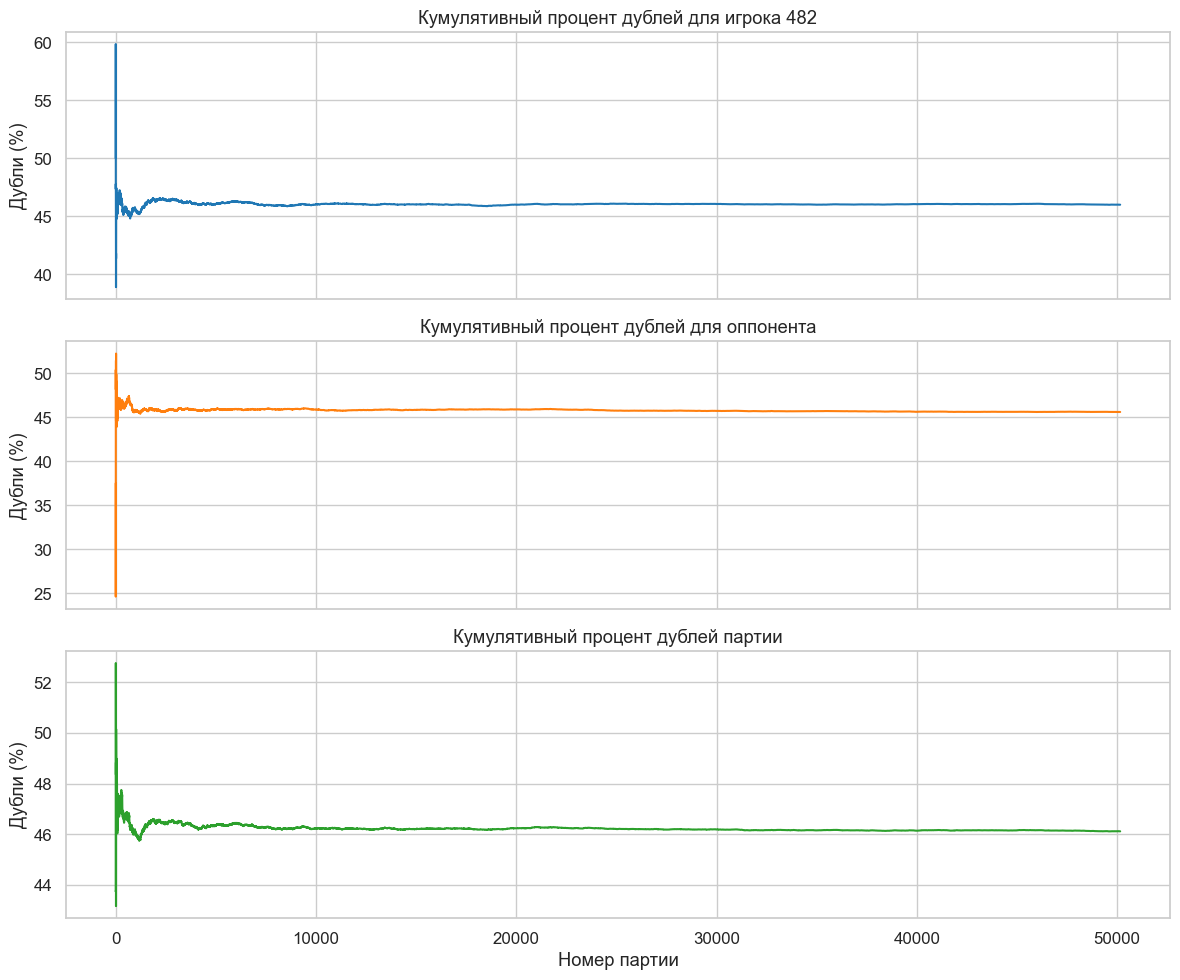

In [24]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

plots = [
    ('dirt_for_me_cummean', f'Кумулятивный процент дублей для игрока {USER_ID}', '#1f77b4'),
    ('dirt_for_op_cummean', 'Кумулятивный процент дублей для оппонента', '#ff7f0e'),
    ('dirty_percent_cummean', 'Кумулятивный процент дублей партии', '#2ca02c'),
]

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for ax, (column, title, color) in zip(axes, plots):
    sns.lineplot(data=df_merged, x=df_merged.index, y=column, ax=ax, color=color)
    ax.set_title(title)
    ax.set_ylabel('Дубли (%)')
    ax.set_xlabel('Номер партии')

plt.tight_layout()
plt.show()

Видим, что все 3 графика с дистанцией выходят на плато, однако это плато находится на значениях, в районе 46%, что не совпадает с аналитической вероятностью дубля или сета

Ну и бонусом посмотрим, на скольки бросках была получена наша статистика

In [25]:
rolls_count = df_merged.total_moves.sum() * 3
print(f"Проанализировано бросков: {int(rolls_count)}")

Проанализировано бросков: 2307957
